In [1]:
import numpy as np
import torch
import psutil
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import random
import sys

In [2]:
sys.path.insert(1, '/home/ubuntu/Intents/Intents-Analysis/Analysis')

In [3]:
from get_vocab import load_data

In [4]:
#Check if cuda is available
cuda = torch.cuda.is_available()
print('CUDA is', cuda)

num_workers = 8 if cuda else 0

print(num_workers)

CUDA is True
8


In [121]:
#Defining constants and labels
max_sent_len = {'english': 247, 'hindi': 265, 'gujarati': 283, 'bengali': 295, 'marathi': 307}
intent_labels = {'movie-tickets':0, 'auto-repair':1, 'restaurant-table':2, 'pizza-ordering':3, 'uber-lyft':4, 'coffee-ordering':5}
language = 'bengali'

#Loading data
train_file = '../Analysis/Labels/TaskMaster/taskmaster_training_' + language + '.pkl'
test_file = '../Analysis/Labels/TaskMaster/taskmaster_testing_' + language + '.pkl'
feature_file = '../Analysis/Labels/TaskMaster/panphon_features_' + language + '.pkl'

train_data = load_data(train_file)
test_data = load_data(test_file)
feature_vectors = load_data(feature_file)


#Add vector for padding, converting feature vectors to float tensors. 
size_of_feature_vector = 22
feature_vectors['unk'] = np.zeros(size_of_feature_vector)
for ipa in feature_vectors:
    feature_vectors[ipa] = torch.from_numpy(feature_vectors[ipa]).float()

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/

In [122]:
def create_input_vector(utterance, feature_vectors, max_len):
    '''
    Pad sentence at the end with maximum length with 'unk' 
    '''
    input_vector = feature_vectors[utterance[0]].reshape(-1,1)
    for ipa in utterance[1:]:
        input_vector = torch.cat((input_vector, feature_vectors[ipa].reshape(-1,1)), dim = 1)
    
    for i in range(max_len - len(utterance)):
        input_vector = torch.cat((input_vector, feature_vectors['unk'].reshape(-1,1)), dim = 1)
        
    return input_vector
    
    

In [123]:
class MyDataset(Dataset):
    def __init__(self, data, feature_vectors, intent_labels, max_len, train = True):
        self.all_data = []
        for intent in data:
            for utterance in data[intent]:
                input_vector = create_input_vector(utterance,feature_vectors, max_len)
                self.all_data.append([input_vector, intent_labels[intent]])
        
        if train:
            random.shuffle(self.all_data)

        self.dim1 = self.all_data[0][0].shape[0]
        self.dim2 = self.all_data[0][0].shape[1]
            
    def __len__(self):
        return len(self.all_data)

    def __getitem__(self,index):

        
        return self.all_data[index][0].reshape(1, self.dim1, self.dim2 ), self.all_data[index][1]

In [124]:
train_dataset = MyDataset(train_data, feature_vectors, intent_labels, max_sent_len[language], train=True)
train_loader_args = dict(shuffle=True, batch_size=128, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=32)
train_loader = DataLoader(train_dataset, **train_loader_args)

test_dataset = MyDataset(test_data, feature_vectors, intent_labels, max_sent_len[language], train=False)
test_loader_args = dict(shuffle=False, batch_size=128, num_workers=num_workers, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = DataLoader(test_dataset, **test_loader_args)

In [125]:
len(test_loader)

3

In [126]:
for data in train_loader:
    print(data[0].shape)

torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([128, 1, 22, 295])
torch.Size([127, 1, 22, 295])


In [132]:
class MyCNN_Model(nn.Module):
    def __init__(self):
        super(MyCNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (1,3)) # (22,245) 
        self.pool1 = nn.MaxPool2d( kernel_size = (1,3), stride = (1,2)) #(22, 122) 
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, (3,5)) # (20,118) 
        self.pool2 = nn.MaxPool2d( kernel_size = (1,2), stride = (1,2)) #(18, 59) 
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 32, (5,7)) # (16, 53)
        self.pool3 = nn.MaxPool2d( kernel_size = (1,3), stride = (1,2)) #(16, 26)
        self.conv3_bn = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32 * 16 * 32, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 64)
        self.fc2_bn = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 6)
        

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))

        x = x.view(-1, 32 *16 * 32)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [141]:
model = MyCNN_Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)
print(optimizer)

MyCNN_Model(
  (conv1): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 3), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(5, 7), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(1, 3), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc1_bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc2_bn): Batch

In [142]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += target.size(0)
        correct_predictions += (predicted == target).sum().item()
    
            
    end_time = time.time()
    
    acc = (correct_predictions/total_predictions)*100.0
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')  
    print('Training Accuracy: ', acc, '%')
    return running_loss

In [143]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [144]:
Train_loss = []
Test_loss = []
Test_acc = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, cooldown=5)

for i in range(50):
    print('epoch:', i)
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)

    #scheduler.step(test_acc)
    for param_group in optimizer.param_groups:
        print('Learning rate:', param_group['lr'])
    

    print('='*20)
    
print(max(Test_acc))

epoch: 0
Training Loss:  1.7534157711526621 Time:  5.5709123611450195 s
Training Accuracy:  25.178389398572886 %
Testing Loss:  1.9731375773747761
Testing Accuracy:  21.0 %
Learning rate: 0.001
epoch: 1
Training Loss:  1.6938334599785183 Time:  6.894856214523315 s
Training Accuracy:  32.31396534148828 %
Testing Loss:  1.9470420281092327
Testing Accuracy:  25.666666666666664 %
Learning rate: 0.001
epoch: 2
Training Loss:  1.6666537212288899 Time:  7.522845268249512 s
Training Accuracy:  32.55181787291879 %
Testing Loss:  1.9287957350413005
Testing Accuracy:  26.333333333333332 %
Learning rate: 0.001
epoch: 3
Training Loss:  1.652148407438527 Time:  5.543845176696777 s
Training Accuracy:  34.08086986068638 %
Testing Loss:  1.873987873395284
Testing Accuracy:  31.0 %
Learning rate: 0.001
epoch: 4
Training Loss:  1.5243639479512754 Time:  5.623064041137695 s
Training Accuracy:  40.97859327217125 %
Testing Loss:  1.589175780614217
Testing Accuracy:  35.66666666666667 %
Learning rate: 0.001


Training Loss:  0.002098693464295534 Time:  8.575011968612671 s
Training Accuracy:  100.0 %
Testing Loss:  1.9112057288487752
Testing Accuracy:  73.33333333333333 %
Learning rate: 0.001
epoch: 38
Training Loss:  0.0018127247534246872 Time:  8.62217116355896 s
Training Accuracy:  100.0 %
Testing Loss:  1.9732702573140461
Testing Accuracy:  73.33333333333333 %
Learning rate: 0.001
epoch: 39
Training Loss:  0.0015696985748313043 Time:  8.595051288604736 s
Training Accuracy:  100.0 %
Testing Loss:  2.010905067125956
Testing Accuracy:  73.0 %
Learning rate: 0.001
epoch: 40
Training Loss:  0.0013393631189778123 Time:  8.084200859069824 s
Training Accuracy:  100.0 %
Testing Loss:  2.06076979637146
Testing Accuracy:  73.33333333333333 %
Learning rate: 0.001
epoch: 41
Training Loss:  0.0012008123195973103 Time:  8.216927766799927 s
Training Accuracy:  100.0 %
Testing Loss:  2.0450535217920938
Testing Accuracy:  73.33333333333333 %
Learning rate: 0.001
epoch: 42
Training Loss:  0.001100377899685

In [ ]:
plt.plot(Test_loss)

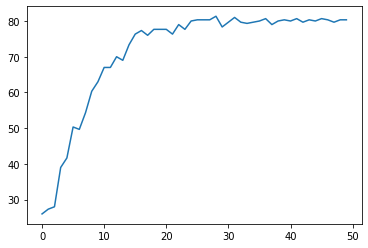

In [81]:
plt.plot(Test_acc)

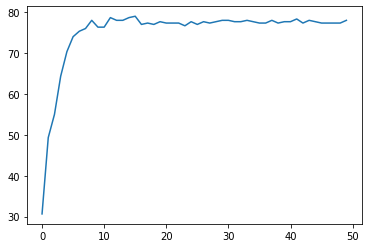

In [87]:
plt.plot(Test_acc)